In [129]:
import pandas as pd
import numpy as np
import re

In [130]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
import joblib

# Rutas a los archivos guardados
model_path =  '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Stacking_3/stack_model_best.joblib'
vectorizer_path = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Stacking_3/tfidf_vectorizer_best.joblib'

# Cargar modelo y vectorizador
stack_model = joblib.load(model_path)
tfidf_vectorizer = joblib.load(vectorizer_path)

In [132]:
from google.colab import files
uploaded = files.upload()

Saving MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv to MEDIQA-CORR-2024-MS-ValidationSet-1-Full (5).csv


In [133]:
df = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv', delimiter=',', encoding='utf-8')
# df= df.drop(['Error Sentence', 'Corrected Text'], axis=1)
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,A 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,A 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,A previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


In [134]:
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')

In [135]:
# Reemplazar caracteres especiales por su equivalente en texto
replacements = {
    "â€\x9d": " ",
    ".â€\x9d": ".",
    "â€“": "-",
    "â€œsomething": "something",
    "patientâ€™s": "patients",
    "â‰¥": "≥",
    "\n": ",",
    "â€œ": "",
    "Waldenstromâ€™s": "Waldenströms",
    "Âµmol/L": "µmol/L",
    "â€œmemory": "memory",
    "weeksâ€™": "weeks",
    "74 Î¼m3": "74 μm^3",
    "ÂµIU/L": "µIU/L",
    "â‰¤": "≤",
    "Clâˆ’": "Cl-",
    "physicianâ€™s": "physicians",
    "ÂºF": "ºF",
    "âˆ’": "-",
    "Â½": "½",
    "Î¼g/dL": "μg/dL",
    "pediatricianâ€™s": "pediatricians",
    "yearsâ€™": "years",
    "Âµg": "µg",
    "â€": "",
    "Kennedyâ€™s": "Kennedys",
    "Kennedy™s": "Kennedys",
    "can™t": "can't",
    "Î²": "β",
    "Ã—": "x",
    "ÃŸ-hCG": "β-hCG",
    "SÃ©quard": "Séquard",
    "Î³": "γ",
    "Î¼m3": "μm^3",
    "Î±": "α",
    "Î¼U/mL": "μU/mL",
    "Î¼": "μ",
    "'": "",
    "\"":"" #Este lo dejo a consideracion, dependiendo si les funciona o no
}

# Aplicar todas las sustituciones
for old, new in replacements.items():
    df['Text'] = df['Text'].str.replace(old, new, regex=False)

# Verificar el reemplazo
df['Text'].head()


0    A 24-year-old woman comes to the emergency dep...
1    A 24-year-old woman comes to the emergency dep...
2    A 43-year-old woman comes to the physician bec...
3    A 4-year-old is brought into the emeregency ro...
4    A previously healthy 25-year-old man comes to ...
Name: Text, dtype: object

In [136]:
import pandas as pd
import re

# Función para aplicar todas las transformaciones no regex en una sola pasada
def optimize_text(text):
    # Aplicar transformaciones no regex
    text = text.strip().replace("Cl- ", "Cl ").replace("'", "").replace("’", "")
    text = text.replace(":,", ":").replace(',_', ',').replace('[', '').replace(']', '')
    text = text.replace(';', ',').replace('.,', '.').replace('mg dl', 'mg/dl')
    text = text.replace('é', 'e').replace('patient s', 'patients').replace('girl s', 'girls')
    text = text.replace('gilbert s', 'gilberts').replace(".'", ".").replace(",'", ",")
    text = text.replace("',", ",").lower()  # Convertir a minúsculas aquí para optimizar
    return text

# Aplicar optimizaciones no regex
df['Text'] = df['Text'].apply(optimize_text)

# Aplicar optimizaciones con regex
df['Text'] = df['Text'].str.replace(r',,', ',', regex=True)
df['Text'] = df['Text'].str.replace(r'  +', ' ', regex=True)
df['Text'] = df['Text'].str.replace('mm hg', 'mmHg', flags=re.IGNORECASE, regex=True)


In [137]:
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,a 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,a 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,a previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


**Modelo 1**

In [138]:
# texts = df['Text'].values  # Extraer los textos para predicción

# # Preprocesar los textos con el vectorizador TF-IDF cargado
# X_new = tfidf_vectorizer.transform(texts)

# # Utilizar el modelo (por ejemplo, stack_model) para hacer predicciones
# new_predictions = stack_model.predict(X_new)

# # Asignar las predicciones a una nueva columna en el DataFrame
# df['Error Flag'] = new_predictions

# # Convertir probabilidades a etiquetas binarias basadas en un umbral de 0.5
# new_predictions_labels = (new_predictions > 0.5).astype(int)

# # Asignar las etiquetas binarias a una nueva columna en el DataFrame
# df['Error Flag'] = new_predictions_labels


In [139]:
texts = df['Text'].values
labels = df['Error Flag'].values

# Preprocesar los textos
X_new = tfidf_vectorizer.transform(texts)

# Utiliza el modelo para hacer predicciones
new_predictions = stack_model.predict(X_new)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular y mostrar métricas de evaluación
accuracy = accuracy_score(labels, new_predictions)
precision = precision_score(labels, new_predictions, average='weighted')
recall = recall_score(labels, new_predictions, average='weighted')
f1 = f1_score(labels, new_predictions, average='weighted')

print(f"Accuracy on new data: {accuracy}")
print(f"Precision on new data: {precision}")
print(f"Recall on new data: {recall}")
print(f"F1 Score on new data: {f1}")


Accuracy on new data: 0.4808362369337979
Precision on new data: 0.49037676485433435
Recall on new data: 0.4808362369337979
F1 Score on new data: 0.4819399013960985


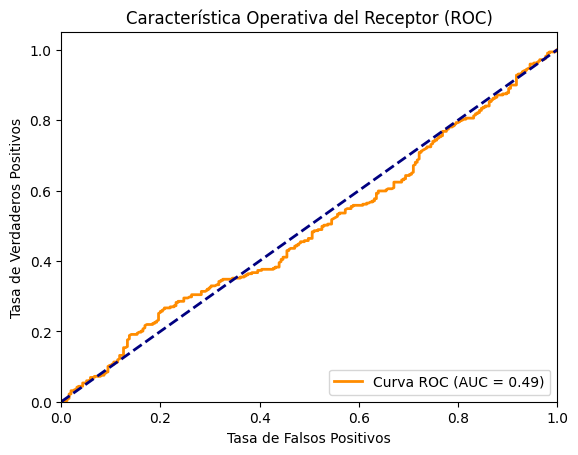

In [140]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Verificar si el modelo puede estimar probabilidades
if hasattr(stack_model, "predict_proba"):
    # Utilizar el modelo para estimar las probabilidades de la clase positiva
    probability_scores = stack_model.predict_proba(X_new)[:, 1]

    # Generar los datos de la curva ROC
    fpr, tpr, thresholds = roc_curve(labels, probability_scores)
    roc_auc = auc(fpr, tpr)  # Calcular el área bajo la curva ROC (AUC)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("El modelo no soporta la estimación de probabilidades con predict_proba.")


In [141]:
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,a 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,a 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,a previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


In [142]:
df= df.drop(['Error Flag'], axis=1)

# Añadir las predicciones al DataFrame
df['Error Flag Pred'] = new_predictions

# Renombrar la columna 'Error Flag Pred' a 'Error Flag'
df.rename(columns={'Error Flag Pred': 'Error Flag'}, inplace=True)

# Seleccionar y conservar únicamente las columnas deseadas
df_final = df[['Text ID', 'Error Flag', 'Error Sentence ID', 'Corrected Sentence']]

# Mostrar las primeras filas del DataFrame final para verificar
print(df_final.head())


    Text ID  Error Flag  Error Sentence ID  \
0  ms-val-0           1                  5   
1  ms-val-1           1                 -1   
2  ms-val-2           0                 24   
3  ms-val-3           0                  4   
4  ms-val-4           1                  0   

                                  Corrected Sentence  
0      Culture tests indicate Trichomonas vaginalis.  
1                                                NaN  
2  Pathology confirms Mycoplasma pneumoniae is th...  
3  Laboratory studies confirm that he has parainf...  
4  A previously healthy 25-year-old man comes to ...  


In [143]:
df_final.head()

,Text ID,Error Flag,Error Sentence ID,Corrected Sentence
0,ms-val-0,1,5,Culture tests indicate Trichomonas vaginalis.
1,ms-val-1,1,-1,NaN
2,ms-val-2,0,24,Pathology confirms Mycoplasma pneumoniae is th...
3,ms-val-3,0,4,Laboratory studies confirm that he has parainf...
4,ms-val-4,1,0,A previously healthy 25-year-old man comes to ...


In [144]:
df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Asegurar un solo espacio entre palabras, incluso si hay múltiples espacios originalmente
df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))

# Guardar el DataFrame modificado a un archivo de texto sin comillas y con un solo espacio
with open('prediction_stacking_3.txt', 'w', encoding='utf-8') as file:
    for item in df_final['formatted']:
        file.write("%s\n" % item)

# Importar la función de descarga de archivos de Colab
from google.colab import files

# Descargar el archivo de texto a tu computadora
files.download('prediction_stacking_3.txt')

<ipython-input-144-c62abf8288c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
<ipython-input-144-c62abf8288c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [145]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_final= df_final.drop(['Error Sentence ID', 'Corrected Sentence'], axis=1)

# Añadir columnas con valores por defecto 'IRLVT'
df_final['Error Sentence ID'] = "-1"
df_final['Corrected Sentence'] = "NaN"


# Mostrar las primeras filas del DataFrame modificado para verificar
print(df_final.head())

    Text ID  Error Flag                                          formatted  \
0  ms-val-0           1  ms-val-0 1 5 Culture tests indicate Trichomona...   
1  ms-val-1           1                                  ms-val-1 1 -1 nan   
2  ms-val-2           0  ms-val-2 0 24 Pathology confirms Mycoplasma pn...   
3  ms-val-3           0  ms-val-3 0 4 Laboratory studies confirm that h...   
4  ms-val-4           1  ms-val-4 1 0 A previously healthy 25-year-old ...   

  Error Sentence ID Corrected Sentence  
0                -1                NaN  
1                -1                NaN  
2                -1                NaN  
3                -1                NaN  
4                -1                NaN  


In [146]:
df_final.head()

,Text ID,Error Flag,formatted,Error Sentence ID,Corrected Sentence
0,ms-val-0,1,ms-val-0 1 5 Culture tests indicate Trichomona...,-1,NaN
1,ms-val-1,1,ms-val-1 1 -1 nan,-1,NaN
2,ms-val-2,0,ms-val-2 0 24 Pathology confirms Mycoplasma pn...,-1,NaN
3,ms-val-3,0,ms-val-3 0 4 Laboratory studies confirm that h...,-1,NaN
4,ms-val-4,1,ms-val-4 1 0 A previously healthy 25-year-old ...,-1,NaN


In [147]:
# Guardar el DataFrame final en un archivo CSV
df_final.to_csv('prediction_2.txt', index=False, header=False, sep=' ')

# Importar la función de descarga de archivos de Colab
from google.colab import files

# Descargar el archivo CSV a tu computadora
files.download('prediction_2.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [148]:
# !zip prediction.zip prediction.txt

In [149]:
# from google.colab import files
# files.download('prediction.zip')
